In [1]:
import iris
import matplotlib.pyplot as plt

import iris.plot as iplt

import numpy
from iris.experimental.regrid import regrid_weighted_curvilinear_to_rectilinear

In [2]:
% matplotlib inline

In [12]:
tauuo_file = '/g/data/ua6/DRSv2/CMIP5/CCSM4/historical/mon/ocean/r1i1p1/tauuo/latest/tauuo_Omon_CCSM4_historical_r1i1p1_185001-200512.nc'
tauvo_file = '/g/data/ua6/DRSv2/CMIP5/CCSM4/historical/mon/ocean/r1i1p1/tauvo/latest/tauvo_Omon_CCSM4_historical_r1i1p1_185001-200512.nc'

In [13]:
tauuo_cube = iris.load_cube(tauuo_file, 'surface_downward_x_stress')
tauvo_cube = iris.load_cube(tauvo_file, 'surface_downward_y_stress')

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [18]:
print(tauuo_cube)

surface_downward_x_stress                  (time: 1872; cell index along second dimension: 384; cell index along first dimension: 320)
     Dimension coordinates:
          time                                  x                                        -                                      -
          cell index along second dimension     -                                        x                                      -
          cell index along first dimension      -                                        -                                      x
     Auxiliary coordinates:
          latitude                              -                                        x                                      x
          longitude                             -                                        x                                      x
     Attributes:
          Conventions: CF-1.4
          acknowledgements: The CESM project is supported by the National Science Foundation and the...
        

In [14]:
print(tauuo_cube.coord_system())

None


In [15]:
target_grid = iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS)

In [16]:
new_tauuo_cube, new_tauvo_cube = iris.analysis.cartography.rotate_winds(tauuo_cube, tauvo_cube, target_grid)

In [17]:
print(new_tauuo_cube)

transformed_surface_downward_x_stress / (N m-2) (time: 1872; cell index along second dimension: 384; cell index along first dimension: 320)
     Dimension coordinates:
          time                                       x                                        -                                      -
          cell index along second dimension          -                                        x                                      -
          cell index along first dimension           -                                        -                                      x
     Auxiliary coordinates:
          latitude                                   -                                        x                                      x
          longitude                                  -                                        x                                      x
          projection_x_coordinate                    -                                        x                                  

In [22]:
new_tauuo_cube.remove_coord('projection_x_coordinate')
new_tauuo_cube.remove_coord('projection_y_coordinate')

In [21]:
def _check_coord_names(cube, coord_names):
    """Remove specified coordinate name.
    The iris standard names for lat/lon coordinates are:
      latitude, grid_latitude, longitude, grid_longitude
    If a cube uses one for the dimension coordinate and the 
      other for the auxillary coordinate, the 
      regrid_weighted_curvilinear_to_rectilinear method won't work
    Args:
      cube (iris.cube.Cube)
      coord_names(list)
    """

    if 'grid_latitude' in coord_names:
        cube.coord('grid_latitude').standard_name = None
        coord_names = [coord.name() for coord in cube.dim_coords]
    if 'grid_longitude' in coord_names:
        cube.coord('grid_longitude').standard_name = None
        coord_names = [coord.name() for coord in cube.dim_coords]

    return cube, coord_names


def _make_grid(lat_values, lon_values):
    """Make a dummy cube with desired grid."""
       
    latitude = iris.coords.DimCoord(lat_values,
                                    standard_name='latitude',
                                    units='degrees_north',
                                    coord_system=iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS))
    longitude = iris.coords.DimCoord(lon_values,                    
                                     standard_name='longitude',
                                     units='degrees_east',
                                     coord_system=iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS))

    dummy_data = numpy.zeros((len(lat_values), len(lon_values)))
    new_cube = iris.cube.Cube(dummy_data, dim_coords_and_dims=[(latitude, 0), (longitude, 1)])

    new_cube.coord('longitude').guess_bounds()
    new_cube.coord('latitude').guess_bounds()

    return new_cube


def get_grid_spacing(cube):
    """Return an array of grid spacings."""

    if not cube.coord('latitude').has_bounds():
        cube.coord('latitude').guess_bounds()

    spacing = [numpy.diff(bounds)[0] for bounds in cube.coord('latitude').bounds]
    
    return numpy.array(spacing)


def get_grid_res(horiz_shape):
    """Define horizontal resolution of new grid. 
    Calculation makes sure new grid is similar resolution to old grid
    (erring on side of slightly more coarse)
    """

    assert len(horiz_shape) == 2
    orig_npoints = horiz_shape[0] * horiz_shape[1]

    res_options = numpy.array([1.0, 1.5, 2.0, 2.5])
    npoints_ref = numpy.array([181 * 360, 121 * 240, 91 * 180, 73 * 144])

    idx = (numpy.abs(npoints_ref - orig_npoints)).argmin()
    
    new_res = res_options[idx]
    if orig_npoints < npoints_ref[idx]:
        new_res = new_res + 0.5

    new_res = new_res + 0.5  # safety buffer

    print("new horizontal grid resolution =", new_res)

    return new_res


def curvilinear_to_rectilinear(cube):
    """Regrid curvilinear data to a rectilinear grid if necessary."""

    coord_names = [coord.name() for coord in cube.dim_coords]
    aux_coord_names = [coord.name() for coord in cube.aux_coords]

    if 'time' in aux_coord_names:
        aux_coord_names.remove('time')
    if 'depth' in aux_coord_names:
        aux_coord_names.remove('depth')

    if aux_coord_names == ['latitude', 'longitude']:

        grid_res = get_grid_res(cube.coord('latitude').shape)

        # Create target grid
        lats = numpy.arange(-90, 90.01, grid_res)
        lons = numpy.arange(0, 360, grid_res)
        target_grid_cube = _make_grid(lats, lons)

        # Interate over slices (experimental regridder only works on 2D slices)
        cube, coord_names = _check_coord_names(cube, coord_names)
        slice_dims = coord_names

        if 'time' in slice_dims:
            slice_dims.remove('time')
        if 'depth' in slice_dims:
            slice_dims.remove('depth')
    
        cube_list = []
        for i, cube_slice in enumerate(cube.slices(slice_dims)):
            weights = numpy.ones(cube_slice.shape)
            cube_slice.coord(axis='x').coord_system = iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS)
            cube_slice.coord(axis='y').coord_system = iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS)
            regridded_cube = regrid_weighted_curvilinear_to_rectilinear(cube_slice, weights, target_grid_cube)
            cube_list.append(regridded_cube)

        new_cube = iris.cube.CubeList(cube_list)
        new_cube = new_cube.merge_cube()
        coord_names = [coord.name() for coord in new_cube.dim_coords]

        regrid_status = True

    else:

        new_cube = cube
        regrid_status = False
    
    return new_cube, coord_names, regrid_status

In [24]:
latlon_tauuo_cube, coord_names, regrid_status = curvilinear_to_rectilinear(new_tauuo_cube)

new horizontal grid resolution = 1.5


In [25]:
print(latlon_tauuo_cube)

transformed_surface_downward_x_stress / (N m-2) (time: 1872; latitude: 121; longitude: 240)
     Dimension coordinates:
          time                                       x               -               -
          latitude                                   -               x               -
          longitude                                  -               -               x
     Attributes:
          Conventions: CF-1.4
          acknowledgements: The CESM project is supported by the National Science Foundation and the...
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: g...
          branch_time: 9.0
          cesm_casename: b40.20th.track1.1deg.008
          cesm_compset: B20TRCN
          cesm_repotag: ccsm4_0_beta43
          cmor_version: 2.8.1
          comment: TAUX, CMIP5_table_comment: This is the stress on the liquid ocean from...
          contact: cesm_data@ucar.edu
          creation_date: 2012-06-17T02:16:07Z
          e

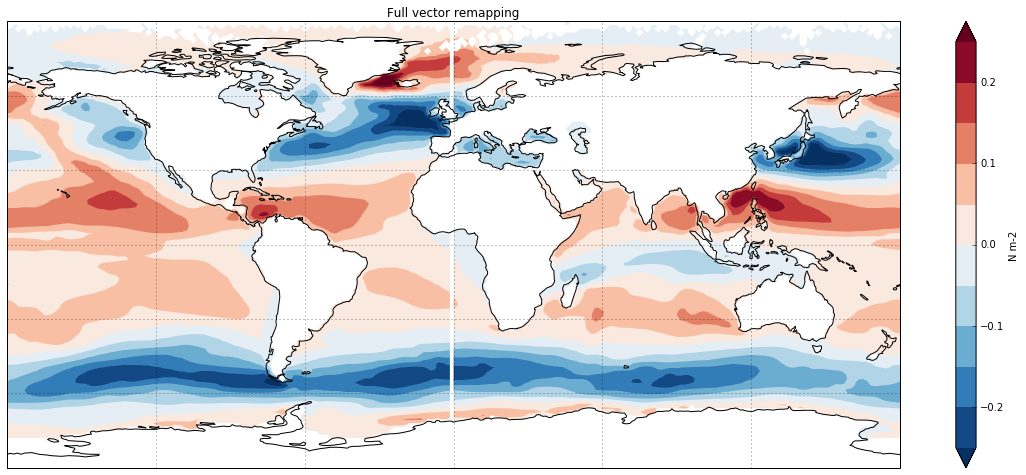

In [27]:
fig = plt.figure(figsize=[20,8])
iplt.contourf(latlon_tauuo_cube[0,::], cmap='RdBu_r',
              levels=[-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.20, 0.25],
              extend='both')
plt.gca().coastlines()
plt.gca().gridlines()
cbar = plt.colorbar()
cbar.set_label(str(latlon_tauuo_cube.units))
plt.title('Full vector remapping')
plt.show()

In [28]:
latlon_scalar_tauuo_cube, coord_names, regrid_status = curvilinear_to_rectilinear(tauuo_cube)

new horizontal grid resolution = 1.5


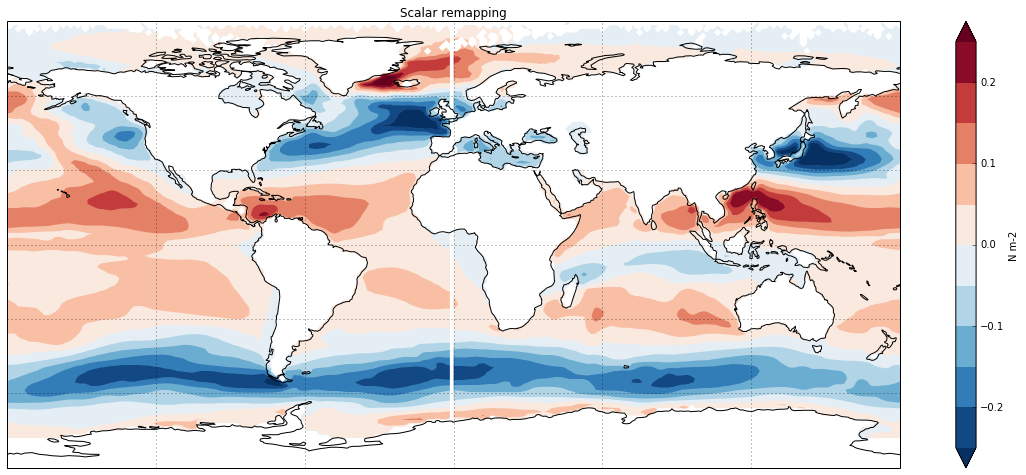

In [29]:
fig = plt.figure(figsize=[20,8])
iplt.contourf(latlon_scalar_tauuo_cube[0,::], cmap='RdBu_r',
              levels=[-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.20, 0.25],
              extend='both')
plt.gca().coastlines()
plt.gca().gridlines()
cbar = plt.colorbar()
cbar.set_label(str(latlon_tauuo_cube.units))
plt.title('Scalar remapping')
plt.show()

In [30]:
tauuo_cube[0,::].data.mean()

0.001555785059357339

In [31]:
new_tauuo_cube[0,::].data.mean()

0.001555785059357339

In [32]:
tauvo_cube[0,::].data.mean()

0.010917040354868906

In [33]:
new_tauvo_cube[0,::].data.mean()

0.010917040354868906

## Just use tauu instead??

In [34]:
tauu_file = '/g/data/ua6/DRSv2/CMIP5/CCSM4/historical/mon/atmos/r1i1p1/tauu/latest/tauu_Amon_CCSM4_historical_r1i1p1_185001-200512.nc'

In [35]:
tauu_cube = iris.load_cube(tauu_file, 'surface_downward_eastward_stress')

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


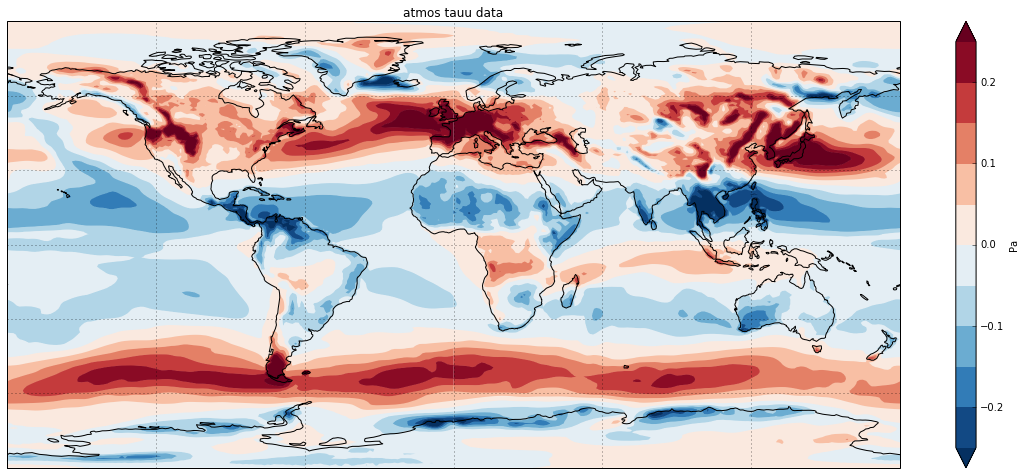

In [36]:
fig = plt.figure(figsize=[20,8])
iplt.contourf(tauu_cube[0,::], cmap='RdBu_r',
              levels=[-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.20, 0.25],
              extend='both')
plt.gca().coastlines()
plt.gca().gridlines()
cbar = plt.colorbar()
cbar.set_label(str(tauu_cube.units))
plt.title('atmos tauu data')
plt.show()